In [2]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# To install sklearn type \pip install numpy scipy scikit-learn\ to the anaconda terminal

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

In [3]:
#ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split

from fbprophet import Prophet

from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

# installing auto arima
# pip install --user pmdarima

# installing fbprophet
# pip install --user fbprophet
# !pip install --upgrade plotly

In [4]:
raw_data = pd.read_csv('C:/projects/research paper/res1/test9bxSample.csv', encoding='latin-1')

# print the shape
print(raw_data.shape)

#runs the first 5 rows
raw_data.head()

(11734, 8)


,demo_ind,indicator,location,Product_Type,Rec_Period_Yr,Qty_Value,flag codes,flags
0,SP_DYN_TFRT_IN,Annual Crop Production (in tonns),ETH,crop Variant A,1970,2.86,NaN,NaN
1,SP_DYN_TFRT_IN,Annual Crop Production (in tonns),ETH,crop Variant A,1971,2.96,NaN,NaN
2,SP_DYN_TFRT_IN,Annual Crop Production (in tonns),ETH,crop Variant A,1972,2.74,NaN,NaN
3,SP_DYN_TFRT_IN,Annual Crop Production (in tonns),ETH,crop Variant A,1973,2.49,NaN,NaN
4,SP_DYN_TFRT_IN,Annual Crop Production (in tonns),ETH,crop Variant A,1974,2.40,NaN,NaN


In [5]:
# to display the null values in the value column
raw_data[raw_data['Qty_Value'].isnull()]

raw_data['indicator'][raw_data['Qty_Value'].isnull()].unique()

# Deleting the NULL values
raw_data = raw_data.dropna(subset = ['Qty_Value'])

# filtering out the last 2 columns
raw_data = raw_data[['demo_ind','indicator','location','Product_Type','Rec_Period_Yr','Qty_Value']]

# Checking for null values
raw_data.isnull().sum()

# Investigate all the elements whithin each Feature 

for column in raw_data:
    unique_vals = np.unique(raw_data[column])
    nr_values = len(unique_vals)
    if nr_values < 36:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))
        
# Eliminating the multiple indicators to one specific indicator (GDP per capita, PPP)
# Filtering out the data we need - GDP per Capita
forecast_data = raw_data[raw_data['indicator'] == 'Annual Crop Production (in tonns)']

# Eliminate out those with problematic data to be Excluded
#forecast_data = forecast_data[~forecast_data['Product_Type'].isin(['crop Variant M', 'crop Variant N'])]

forecast_data.head()



# Limiting the columns we need
forecast_data = forecast_data[['Product_Type','Rec_Period_Yr','Qty_Value']]
forecast_data.head()


# Changing the time to date - Most Time Series Models require date structure
forecast_data['Rec_Period_Yr'] = forecast_data['Rec_Period_Yr'].astype(str) + '-01-01'
forecast_data['Rec_Period_Yr'] = pd.to_datetime(forecast_data['Rec_Period_Yr'])

forecast_data.head()



The number of values for feature demo_ind :35 -- ['200101' '200144' '200151' '200343' '200345' 'DT_TDS_DECT_GN_ZS'
 'NY_GDP_DEFL_ZS' 'NY_GDP_MKTP_CD' 'NY_GDP_MKTP_CN' 'NY_GDP_MKTP_KD'
 'NY_GDP_MKTP_KD_ZG' 'NY_GDP_MKTP_KN' 'NY_GDP_MKTP_PP_CD'
 'NY_GDP_MKTP_PP_KD' 'NY_GDP_PCAP_CD' 'NY_GDP_PCAP_CN' 'NY_GDP_PCAP_PP_CD'
 'NY_GDP_PCAP_PP_KD' 'NY_GNP_MKTP_CN' 'NY_GNP_PCAP_CD' 'NY_GNP_PCAP_CN'
 'NY_GNP_PCAP_PP_CD' 'PA_NUS_ATLS' 'PA_NUS_FCRF' 'PA_NUS_PPP'
 'PA_NUS_PPPC_RF' 'PA_NUS_PRVT_PP' 'SH_DYN_AIDS_ZS' 'SI_POV_DDAY'
 'SP_DYN_IMRT_IN' 'SP_DYN_LE00_IN' 'SP_DYN_TFRT_IN' 'SP_POP_GROW'
 'SP_RUR_TOTL_ZS' 'XTGOV_IMF']
The number of values for feature indicator :35 -- ['Annual Crop Production (in tonns)'
 'DEC alternative conversion factor (LCU per US$)' 'GDP (constant LCU)'
 'GDP (current LCU)' 'GDP (current US$)'
 'GDP at market prices (constant 2010 US$)'
 'GDP deflator (base year varies by country)' 'GDP growth (annual %)'
 'GDP per capita (current LCU)' 'GDP per capita (current US$)'
 'GDP per

,Product_Type,Rec_Period_Yr,Qty_Value
0,crop Variant A,1970-01-01,2.86
1,crop Variant A,1971-01-01,2.96
2,crop Variant A,1972-01-01,2.74
3,crop Variant A,1973-01-01,2.49
4,crop Variant A,1974-01-01,2.40


In [6]:
X_train = forecast_data[forecast_data['Rec_Period_Yr'] < '2012-01-01']
X_valid = forecast_data[forecast_data['Rec_Period_Yr'] >= '2011-01-01']

print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_train['Rec_Period_Yr'].unique()

# filtering the train data
au = X_train[X_train['Product_Type'] == 'crop Variant A']
au2 = au[['Rec_Period_Yr', 'Qty_Value']]

#filtering the valid data
au_v = X_valid[X_valid['Product_Type'] == 'crop Variant A']
au_v2 = au_v[['Rec_Period_Yr', 'Qty_Value']]

# set the date into index
au2.set_index('Rec_Period_Yr', inplace=True)
au_v2.set_index('Rec_Period_Yr', inplace=True)

# Setting the Index for 6 years
index_7_years = pd.date_range(au2.index[-1], freq='AS', periods = 7) 

index_7_years

len(X_train['Product_Type'].unique())

X_train Shape (378, 3)
X_Valid Shape (63, 3)


9

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MSE of prophet is: 0.17290160941808141


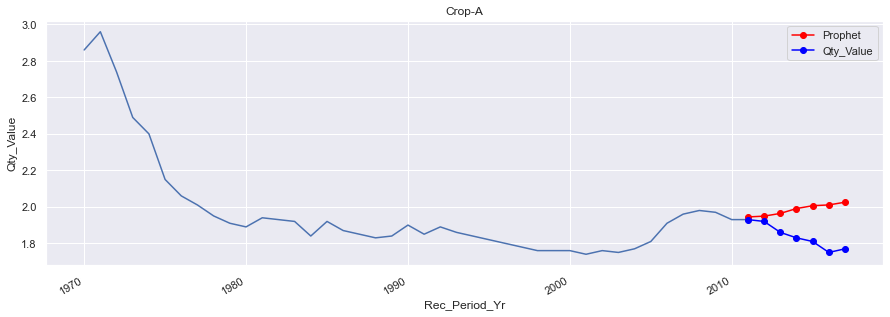

In [7]:
# prepare expected column names
au3 = au.copy()
au3 = au3[['Rec_Period_Yr', 'Qty_Value']]
au3.columns = ['ds', 'y']
au3['ds']= to_datetime(au3['ds'])

# define the model
model = Prophet()
# fit the model
model.fit(au3)

# define the period for which we want a prediction
df_index_7_years = pd.DataFrame(index_7_years)
df_index_7_years.columns = ['ds']
df_index_7_years['ds']= to_datetime(df_index_7_years['ds'])

# use the model to make a forecast
fcast3 = model.predict(df_index_7_years)
fcast3 = pd.Series(fcast3['yhat'].values, index=index_7_years)
fcast3 = fcast3.rename("Prophet")

# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='Rec_Period_Yr', y='Qty_Value', data = au)
chart.set_title('Crop-A')
fcast3.plot(ax=ax, color='red', marker="o", legend=True)
au_v2.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the AI
print('The MSE of prophet is:', mean_squared_error(au_v['Qty_Value'].values, fcast3.values, squared=False))

In [8]:
model.predict(df_index_7_years)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,-1.252310,1.857325,2.035926,-1.252310,-1.252310,3.196963,3.196963,3.196963,3.196963,3.196963,3.196963,0.0,0.0,0.0,1.944653
1,2012-01-01,-1.236941,1.859681,2.034715,-1.239192,-1.235251,3.185938,3.185938,3.185938,3.185938,3.185938,3.185938,0.0,0.0,0.0,1.948997
2,2013-01-01,-1.221531,1.882156,2.049334,-1.229790,-1.214016,3.185462,3.185462,3.185462,3.185462,3.185462,3.185462,0.0,0.0,0.0,1.963931
3,2014-01-01,-1.206162,1.909888,2.082166,-1.223941,-1.190674,3.196803,3.196803,3.196803,3.196803,3.196803,3.196803,0.0,0.0,0.0,1.990641
4,2015-01-01,-1.190794,1.910125,2.091963,-1.218715,-1.163611,3.196963,3.196963,3.196963,3.196963,3.196963,3.196963,0.0,0.0,0.0,2.006169
5,2016-01-01,-1.175426,1.912342,2.097163,-1.215930,-1.135757,3.185938,3.185938,3.185938,3.185938,3.185938,3.185938,0.0,0.0,0.0,2.010513
6,2017-01-01,-1.160015,1.925340,2.128280,-1.214372,-1.105916,3.185462,3.185462,3.185462,3.185462,3.185462,3.185462,0.0,0.0,0.0,2.025447


### Running All Time Series Models Together

In [9]:
countries = forecast_data['Product_Type'].unique()
countries

array(['crop Variant A', 'crop Variant D', 'crop Variant B',
       'crop Variant C', 'crop Variant E', 'crop Variant F',
       'crop Variant G', 'crop Variant I', 'crop Variant H'], dtype=object)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:title={'center':'crop Variant H'}, xlabel='Rec_Period_Yr', ylabel='Qty_Value'>

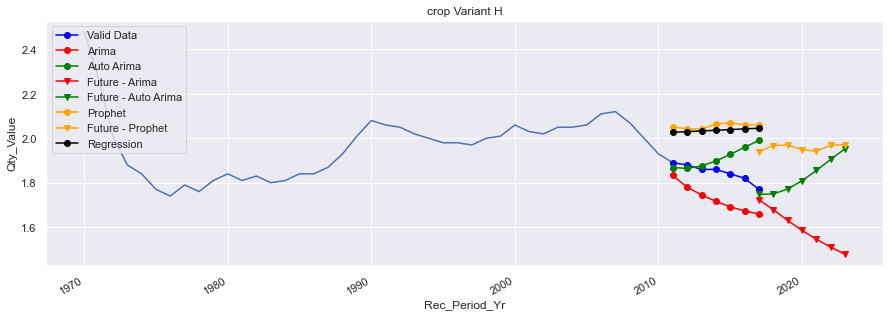

In [10]:
# Step 1 - Arima & Auto-Arima
    
    # creating a country list
crops = forecast_data['Product_Type'].unique()
    
crops = ['crop Variant A']
    
for c in countries:
        # filtering the train data
    train_data = X_train[X_train['Product_Type'] == c] # 3 columns
    train_data2 = train_data[['Rec_Period_Yr', 'Qty_Value']] # 2 columns
        
        # filtering the valid data
    valid_data = X_valid[X_valid['Product_Type'] == c]
    valid_data2 = valid_data[['Rec_Period_Yr', 'Qty_Value']]
        
        # all data
    all_data = forecast_data[forecast_data['Product_Type']==c]
    all_data2 = all_data[['Rec_Period_Yr', 'Qty_Value']]
        
        #convert date column to datetime
    train_data2.set_index('Rec_Period_Yr', inplace=True)
    valid_data2.set_index('Rec_Period_Yr', inplace=True)
    valid_data2.columns = ['Valid Data']    
    all_data2.set_index('Rec_Period_Yr', inplace=True)
        
    
        # Setting the Valid - Index for 7 years
    index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 
        
        # Setting the Future - Index for 7 years
    future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 
        
        # Dropping all tables
    try:
        del t_fcast1
        del t_fcast2
            #del t_fcast3
            
        del f_fcast1
        del f_fcast2
            #del f_fcast3       
            
    except:
            print("")
    
    try:
        del df_fcast1
        del df_fcast2
        del df_fcast3
    except:
        print("")
        
        
        
##############################################################################################################
######################################            ARIMA             ##########################################  
##############################################################################################################

# THIS IS FOR THE VALIDATION PHASE 
try:        
	try:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(train_data2, order=(0,2,3))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		t_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
		t_fcast1 = t_fcast1.rename("Arima") 
	except:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(train_data2, order=(4,1,0))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		t_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
		t_fcast1 = t_fcast1.rename("Arima") 
except:
	print(c, "Arima Train Error")
	
 # THIS IS FOR THE FUTURE PHASE
try:        
	try:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(all_data2, order=(0,2,3))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		f_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
		f_fcast1 = f_fcast1.rename("Future - Arima") 
	except:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(all_data2, order=(4,1,0))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		f_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
		f_fcast1 = f_fcast1.rename("Future - Arima") 
except:
	print(c, "Arima Future Error")   
	
##############################################################################################################
######################################      AUTO - ARIMA             ######################################### 
##############################################################################################################

# THIS IS FOR THE VALIDATION PHASE
try:
	# Running auto ARIMA 
	auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

	# make your forecasts
	t_fcast2 = auto_arima_model.predict(7) 
	t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
	t_fcast2 = t_fcast2.rename("Auto Arima")

except:
	print(c, "Auto Arima Train Error") 
	
 # THIS IS FOR THE FUTURE PHASE
try:
	# Running auto ARIMA Future
	auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

	# make your forecasts
	f_fcast2 = auto_arima_model.predict(7) 
	f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
	f_fcast2 = f_fcast2.rename("Future - Auto Arima")

except:
	print(c, "Auto Arima Train Error")  

##############################################################################################################
######################################      PROPHET             ############################################## 
##############################################################################################################

# prepare expected column names
train_data3 = train_data.copy()
train_data3 = train_data3[['Rec_Period_Yr', 'Qty_Value']]
train_data3.columns = ['ds', 'y']
train_data3['ds']= to_datetime(train_data3['ds'])

all_data3 = all_data.copy()
all_data3 = all_data3[['Rec_Period_Yr', 'Qty_Value']]
all_data3.columns = ['ds', 'y']
all_data3['ds']= to_datetime(all_data3['ds'])

# define the period for which we want a prediction - Valid
v_df_index_7_years = pd.DataFrame(index_7_years)
v_df_index_7_years.columns = ['ds']
v_df_index_7_years['ds']= to_datetime(v_df_index_7_years['ds'])

# define the period for which we want a prediction - Future
f_df_index_7_years = pd.DataFrame(future_index_7_years)
f_df_index_7_years.columns = ['ds']
f_df_index_7_years['ds']= to_datetime(f_df_index_7_years['ds'])

############### THIS IS FOR THE VALIDATION PHASE  ##################

# define the model
model = Prophet()
# fit the model
model.fit(train_data3)

# use the model to make a forecast
t_fcast3 = model.predict(v_df_index_7_years)
t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_7_years)
t_fcast3 = t_fcast3.rename("Prophet")

############### THIS IS FOR THE VALIDATION PHASE  ##################

# define the model
model2 = Prophet()
# fit the model
model2.fit(all_data3)

# use the model to make a forecast
f_fcast3 = model2.predict(f_df_index_7_years)
f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_7_years)
f_fcast3 = f_fcast3.rename("Future - Prophet")  

##############################################################################################################
########################################         Regression         ##########################################
##############################################################################################################

# Creating Ordinal Dates
train_data['MonthNumberOrdinal'] = train_data['Rec_Period_Yr']
train_data['MonthNumberOrdinal'] = pd.to_datetime(train_data['MonthNumberOrdinal']).map(datetime.toordinal)

all_data['MonthNumberOrdinal'] = all_data['Rec_Period_Yr']
all_data['MonthNumberOrdinal'] = pd.to_datetime(all_data['MonthNumberOrdinal']).map(datetime.toordinal)

# adding the ordinal dates to the prediction dates
v_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(v_df_index_7_years['ds']).map(datetime.toordinal)
f_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(f_df_index_7_years['ds']).map(datetime.toordinal)


# Fitting LR on Valid
reg = linear_model.LinearRegression()
reg.fit(train_data['MonthNumberOrdinal'].values.reshape(-1, 1), train_data['Qty_Value'].values)

# Making predictions
t_fcast4 = reg.predict(v_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

# Passing the same index as the others
t_fcast4 = pd.Series(t_fcast4, index=index_7_years)
t_fcast4 = t_fcast4.rename("Regression")

# Fitting LR on Future
reg2 = linear_model.LinearRegression()
reg2.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['Qty_Value'].values)

# Making predictions
f_fcast4 = reg2.predict(f_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

# Passing the same index as the others
f_fcast4 = pd.Series(f_fcast4, index=future_index_7_years)
f_fcast4 = f_fcast4.rename("Future - Regression")

##############################################################################################################
########################################      SAVING THE MSE        ##########################################
##############################################################################################################

t_fcast1_mse = mean_squared_error(valid_data['Qty_Value'].values, t_fcast1.values, squared=False)
t_fcast2_mse = mean_squared_error(valid_data['Qty_Value'].values, t_fcast2.values, squared=False)
t_fcast3_mse = mean_squared_error(valid_data['Qty_Value'].values, t_fcast3.values, squared=False)
t_fcast4_mse = mean_squared_error(valid_data['Qty_Value'].values, t_fcast4.values, squared=False)

##############################################################################################################
########################################      PLOTTING              ##########################################
##############################################################################################################

fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='Rec_Period_Yr', y='Qty_Value', data = train_data)
chart.set_title(c)
valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
# ploting validation
try:
	t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
except:
	print("")        
try:
	t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
except:
	print("")
	
# plotting future
try:
	f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
except:
	print("")        
try:
	f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
except:
	print("") 

t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)

t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
# f_fcast4.plot(ax=ax, color='black', marker="v", legend=True)

In [17]:
# future_index_7_years

DatetimeIndex(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01',
               '2021-01-01', '2022-01-01', '2023-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [ ]:
#################################################################################################################

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:title={'center':'crop Variant A'}, xlabel='Rec_Period_Yr', ylabel='Qty_Value'>

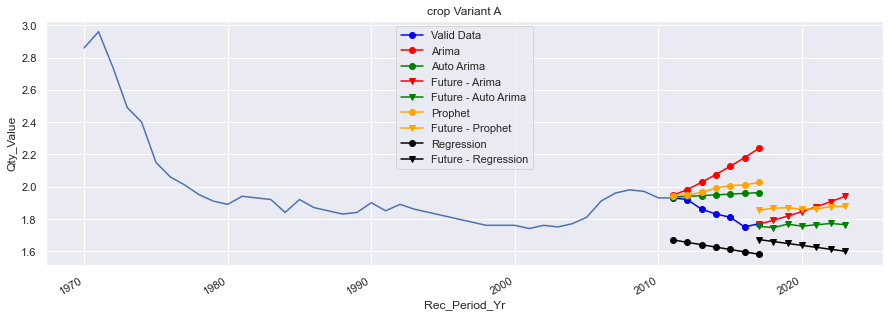

In [14]:
# Step 2bbbb - Adding Prophet and Regression

# creating a Product_Type list
crops = forecast_data['Product_Type'].unique()

crops = ['crop Variant A']

for c in crops:
# filtering the train data
    train_data = X_train[X_train['Product_Type'] == c]
    train_data2 = train_data[['Rec_Period_Yr', 'Qty_Value']]

# filtering the valid data
valid_data = X_valid[X_valid['Product_Type'] == c]
valid_data2 = valid_data[['Rec_Period_Yr', 'Qty_Value']]

# all data
all_data = forecast_data[forecast_data['Product_Type']==c]
all_data2 = all_data[['Rec_Period_Yr', 'Qty_Value']]

#convert date column to datetime
train_data2.set_index('Rec_Period_Yr', inplace=True)
valid_data2.set_index('Rec_Period_Yr', inplace=True)
valid_data2.columns = ['Valid Data']    
all_data2.set_index('Rec_Period_Yr', inplace=True)


# Setting the Valid - Index for 7 years
index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 

# Setting the Future - Index for 7 years
future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 

# Dropping all tables
try:
	del t_fcast1
	del t_fcast2
	del t_fcast3
	del t_fcast4
	
	del f_fcast1
	del f_fcast2
	del f_fcast3       
	del f_fcast4
	
except:
	print("")

try:
	del df_fcast1
	del df_fcast2
	del df_fcast3
except:
	print("")
	
##############################################################################################################
######################################            ARIMA             ##########################################  
##############################################################################################################

# THIS IS FOR THE VALIDATION PHASE 
try:        
	try:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(train_data2, order=(0,2,3))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		t_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
		t_fcast1 = t_fcast1.rename("Arima") 
	except:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(train_data2, order=(4,1,0))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		t_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
		t_fcast1 = t_fcast1.rename("Arima") 
except:
	print(c, "Arima Train Error")
	
 # THIS IS FOR THE FUTURE PHASE
try:        
	try:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(all_data2, order=(0,2,3))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		f_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
		f_fcast1 = f_fcast1.rename("Future - Arima") 
	except:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(all_data2, order=(4,1,0))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		f_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
		f_fcast1 = f_fcast1.rename("Future - Arima") 
except:
	print(c, "Arima Future Error")   
	
##############################################################################################################
######################################      AUTO - ARIMA             ######################################### 
##############################################################################################################

# THIS IS FOR THE VALIDATION PHASE
try:
	# Running auto ARIMA 
	auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

	# make your forecasts
	t_fcast2 = auto_arima_model.predict(7) 
	t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
	t_fcast2 = t_fcast2.rename("Auto Arima")

except:
	print(c, "Auto Arima Train Error") 
	
 # THIS IS FOR THE FUTURE PHASE
try:
	# Running auto ARIMA Future
	auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

	# make your forecasts
	f_fcast2 = auto_arima_model.predict(7) 
	f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
	f_fcast2 = f_fcast2.rename("Future - Auto Arima")

except:
	print(c, "Auto Arima Train Error")  

##############################################################################################################
######################################      PROPHET             ############################################## 
##############################################################################################################

# prepare expected column names
train_data3 = train_data.copy()
train_data3 = train_data3[['Rec_Period_Yr', 'Qty_Value']]
train_data3.columns = ['ds', 'y']
train_data3['ds']= to_datetime(train_data3['ds'])

all_data3 = all_data.copy()
all_data3 = all_data3[['Rec_Period_Yr', 'Qty_Value']]
all_data3.columns = ['ds', 'y']
all_data3['ds']= to_datetime(all_data3['ds'])

# define the period for which we want a prediction - Valid
v_df_index_7_years = pd.DataFrame(index_7_years)
v_df_index_7_years.columns = ['ds']
v_df_index_7_years['ds']= to_datetime(v_df_index_7_years['ds'])

# define the period for which we want a prediction - Future
f_df_index_7_years = pd.DataFrame(future_index_7_years)
f_df_index_7_years.columns = ['ds']
f_df_index_7_years['ds']= to_datetime(f_df_index_7_years['ds'])

############### THIS IS FOR THE VALIDATION PHASE  ##################

# define the model
model = Prophet()
# fit the model
model.fit(train_data3)

# use the model to make a forecast
t_fcast3 = model.predict(v_df_index_7_years)
t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_7_years)
t_fcast3 = t_fcast3.rename("Prophet")

############### THIS IS FOR THE VALIDATION PHASE  ##################

# define the model
model2 = Prophet()
# fit the model
model2.fit(all_data3)

# use the model to make a forecast
f_fcast3 = model2.predict(f_df_index_7_years)
f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_7_years)
f_fcast3 = f_fcast3.rename("Future - Prophet")  

##############################################################################################################
########################################         Regression         ##########################################
##############################################################################################################

# Creating Ordinal Dates
train_data['MonthNumberOrdinal'] = train_data['Rec_Period_Yr']
train_data['MonthNumberOrdinal'] = pd.to_datetime(train_data['MonthNumberOrdinal']).map(datetime.toordinal)

all_data['MonthNumberOrdinal'] = all_data['Rec_Period_Yr']
all_data['MonthNumberOrdinal'] = pd.to_datetime(all_data['MonthNumberOrdinal']).map(datetime.toordinal)

# adding the ordinal dates to the prediction dates
v_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(v_df_index_7_years['ds']).map(datetime.toordinal)
f_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(f_df_index_7_years['ds']).map(datetime.toordinal)


# Fitting LR on Valid
reg = linear_model.LinearRegression()
reg.fit(train_data['MonthNumberOrdinal'].values.reshape(-1, 1), train_data['Qty_Value'].values)

# Making predictions
t_fcast4 = reg.predict(v_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

# Passing the same index as the others
t_fcast4 = pd.Series(t_fcast4, index=index_7_years)
t_fcast4 = t_fcast4.rename("Regression")

# Fitting LR on Future
reg2 = linear_model.LinearRegression()
reg2.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['Qty_Value'].values)

# Making predictions
f_fcast4 = reg2.predict(f_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

# Passing the same index as the others
f_fcast4 = pd.Series(f_fcast4, index=future_index_7_years)
f_fcast4 = f_fcast4.rename("Future - Regression")

##############################################################################################################
########################################      SAVING THE MSE        ##########################################
##############################################################################################################

t_fcast1_mse = mean_squared_error(valid_data['Qty_Value'].values, t_fcast1.values, squared=False)
t_fcast2_mse = mean_squared_error(valid_data['Qty_Value'].values, t_fcast2.values, squared=False)
t_fcast3_mse = mean_squared_error(valid_data['Qty_Value'].values, t_fcast3.values, squared=False)
t_fcast4_mse = mean_squared_error(valid_data['Qty_Value'].values, t_fcast4.values, squared=False)

##############################################################################################################
########################################      PLOTTING              ##########################################
##############################################################################################################

fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='Rec_Period_Yr', y='Qty_Value', data = train_data)
chart.set_title(c)
valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
# ploting validation
try:
	t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
except:
	print("")        
try:
	t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
except:
	print("")
	
# plotting future
try:
	f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
except:
	print("")        
try:
	f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
except:
	print("") 

t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)

t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
f_fcast4.plot(ax=ax, color='black', marker="v", legend=True) 



INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


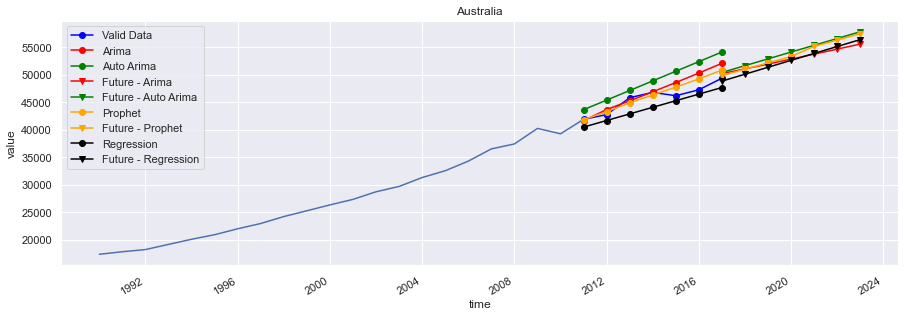

In [21]:
# Step 3 - Saving the results

# creating a country list
countries = forecast_data['Product_Type'].unique()

countries = ['Australia']

for c in countries:
# filtering the train data
    train_data = X_train[X_train['country'] == c]
    train_data2 = train_data[['time', 'value']]

# filtering the valid data
valid_data = X_valid[X_valid['country'] == c]
valid_data2 = valid_data[['time', 'value']]

# all data
all_data = forecast_data[forecast_data['country']==c]
all_data2 = all_data[['time', 'value']]

#convert date column to datetime
train_data2.set_index('time', inplace=True)
valid_data2.set_index('time', inplace=True)
valid_data2.columns = ['Valid Data']    
all_data2.set_index('time', inplace=True)


# Setting the Valid - Index for 6 years
index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 

# Setting the Future - Index for 6 years
future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 

# Dropping all tables
try:
	del t_fcast1
	del t_fcast2
	del t_fcast3
	del t_fcast4
	
	del f_fcast1
	del f_fcast2
	del f_fcast3 
	del f_fcast4
	
except:
	print("")

try:
	del df_fcast1
	del df_fcast2
	del df_fcast3
	del df_fcast4
except:
	print("")
	
##############################################################################################################
######################################            ARIMA             ##########################################  
##############################################################################################################

# THIS IS FOR THE VALIDATION PHASE 
try:        
	try:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(train_data2, order=(0,2,3))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		t_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
		t_fcast1 = t_fcast1.rename("Arima") 
	except:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(train_data2, order=(4,1,0))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		t_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
		t_fcast1 = t_fcast1.rename("Arima") 
except:
	print(c, "Arima Train Error")
	
 # THIS IS FOR THE FUTURE PHASE
try:        
	try:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(all_data2, order=(0,2,3))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		f_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
		f_fcast1 = f_fcast1.rename("Future - Arima") 
	except:
		# Running ARIMA on Best parameter
		model_arima = ARIMA(all_data2, order=(4,1,0))
		model_arima_fit = model_arima.fit(disp=-1)

		# Saving ARIMA predictions
		f_fcast1 = model_arima_fit.forecast(7)[0]
		# Passing the same index as the others
		f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
		f_fcast1 = f_fcast1.rename("Future - Arima") 
except:
	print(c, "Arima Future Error")   
	
##############################################################################################################
######################################      AUTO - ARIMA             ######################################### 
##############################################################################################################

# THIS IS FOR THE VALIDATION PHASE
try:
	# Running auto ARIMA 
	auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

	# make your forecasts
	t_fcast2 = auto_arima_model.predict(7) 
	t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
	t_fcast2 = t_fcast2.rename("Auto Arima")

except:
	print(c, "Auto Arima Train Error") 
	
 # THIS IS FOR THE FUTURE PHASE
try:
	# Running auto ARIMA Future
	auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

	# make your forecasts
	f_fcast2 = auto_arima_model.predict(7) 
	f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
	f_fcast2 = f_fcast2.rename("Future - Auto Arima")

except:
	print(c, "Auto Arima Train Error")  

##############################################################################################################
######################################      PROPHET             ############################################## 
##############################################################################################################

# prepare expected column names
train_data3 = train_data.copy()
train_data3 = train_data3[['time', 'value']]
train_data3.columns = ['ds', 'y']
train_data3['ds']= to_datetime(train_data3['ds'])

all_data3 = all_data.copy()
all_data3 = all_data3[['time', 'value']]
all_data3.columns = ['ds', 'y']
all_data3['ds']= to_datetime(all_data3['ds'])

# define the period for which we want a prediction - Valid
v_df_index_7_years = pd.DataFrame(index_7_years)
v_df_index_7_years.columns = ['ds']
v_df_index_7_years['ds']= to_datetime(v_df_index_7_years['ds'])

# define the period for which we want a prediction - Future
f_df_index_7_years = pd.DataFrame(future_index_7_years)
f_df_index_7_years.columns = ['ds']
f_df_index_7_years['ds']= to_datetime(f_df_index_7_years['ds'])

############### THIS IS FOR THE VALIDATION PHASE  ##################

# define the model
model = Prophet()
# fit the model
model.fit(train_data3)

# use the model to make a forecast
t_fcast3 = model.predict(v_df_index_7_years)
t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_7_years)
t_fcast3 = t_fcast3.rename("Prophet")

############### THIS IS FOR THE VALIDATION PHASE  ##################

# define the model
model2 = Prophet()
# fit the model
model2.fit(all_data3)

# use the model to make a forecast
f_fcast3 = model2.predict(f_df_index_7_years)
f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_7_years)
f_fcast3 = f_fcast3.rename("Future - Prophet")  

##############################################################################################################
########################################         Regression         ##########################################
##############################################################################################################

# Creating Ordinal Dates
train_data['MonthNumberOrdinal'] = train_data['time']
train_data['MonthNumberOrdinal'] = pd.to_datetime(train_data['MonthNumberOrdinal']).map(datetime.toordinal)

all_data['MonthNumberOrdinal'] = all_data['time']
all_data['MonthNumberOrdinal'] = pd.to_datetime(all_data['MonthNumberOrdinal']).map(datetime.toordinal)

# adding the ordinal dates to the prediction dates
v_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(v_df_index_7_years['ds']).map(datetime.toordinal)
f_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(f_df_index_7_years['ds']).map(datetime.toordinal)


# Fitting LR on Valid
reg = linear_model.LinearRegression()
reg.fit(train_data['MonthNumberOrdinal'].values.reshape(-1, 1), train_data['value'].values)

# Making predictions
t_fcast4 = reg.predict(v_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

# Passing the same index as the others
t_fcast4 = pd.Series(t_fcast4, index=index_7_years)
t_fcast4 = t_fcast4.rename("Regression")

# Fitting LR on Future
reg2 = linear_model.LinearRegression()
reg2.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['value'].values)

# Making predictions
f_fcast4 = reg2.predict(f_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

# Passing the same index as the others
f_fcast4 = pd.Series(f_fcast4, index=future_index_7_years)
f_fcast4 = f_fcast4.rename("Future - Regression")

##############################################################################################################
########################################      SAVING THE MSE        ##########################################
##############################################################################################################

t_fcast1_mse = mean_squared_error(valid_data['value'].values, t_fcast1.values, squared=False)
t_fcast2_mse = mean_squared_error(valid_data['value'].values, t_fcast2.values, squared=False)
t_fcast3_mse = mean_squared_error(valid_data['value'].values, t_fcast3.values, squared=False)
t_fcast4_mse = mean_squared_error(valid_data['value'].values, t_fcast4.values, squared=False)

##############################################################################################################
########################################      PLOTTING              ##########################################
##############################################################################################################

fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='time', y='value', data = train_data)
chart.set_title(c)
valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
# ploting validation
try:
	t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
except:
	print("")        
try:
	t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
except:
	print("")
	
# plotting future
try:
	f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
except:
	print("")        
try:
	f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
except:
	print("") 

t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)

t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
f_fcast4.plot(ax=ax, color='black', marker="v", legend=True)  
	
##############################################################################################################
########################################      SAVING THE RESULTS     #########################################
##############################################################################################################

try:
	# Creating a DF for fcast1
	t_fcast1 = t_fcast1.reset_index()
	t_fcast1.columns = ['Date','Arima ForecastValue Validation']

	f_fcast1 = f_fcast1.reset_index()
	f_fcast1.columns = ['Date','Arima ForecastValue Future']

	# Creating the extra columns
	t_fcast1['Arima ForecastValue Future'] = np.nan
	f_fcast1['Arima ForecastValue Validation'] = np.nan

	# reordering 1 only
	t_fcast1 = t_fcast1[['Date','Arima ForecastValue Future','Arima ForecastValue Validation']]

	# Joining them together
	df_fcast1 = pd.concat([t_fcast1, f_fcast1], axis=0)
	df_fcast1['Country'] = c
	df_fcast1['ML Method'] = 'Arima'
	df_fcast1['Arima MSE'] = t_fcast1_mse

except:
	df_fcast1 = pd.DataFrame({'Date': [np.nan], 'Arima ForecastValue Future': [np.nan],'Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Arima'], 'Arima MSE':[np.nan]})

try:
	# Creating a DF for fcast2
	t_fcast2 = t_fcast2.reset_index()
	t_fcast2.columns = ['Date','Auto-Arima ForecastValue Validation']

	f_fcast2 = f_fcast2.reset_index()
	f_fcast2.columns = ['Date','Auto-Arima ForecastValue Future']

	# Creating the extra columns
	t_fcast2['Auto-Arima ForecastValue Future'] = np.nan
	f_fcast2['Auto-Arima ForecastValue Validation'] = np.nan

	# reordering 1 only
	t_fcast2 = t_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation']]

	# Joining them together
	df_fcast2 = pd.concat([t_fcast2, f_fcast2], axis=0)
	df_fcast2['Country'] = c
	df_fcast2['ML Method'] = 'Auto-Arima'
	df_fcast2['Auto-Arima MSE'] = t_fcast2_mse

except:
	df_fcast2 = pd.DataFrame({'Date': [np.nan], 'Auto-Arima ForecastValue Future': [np.nan],'Auto-Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
	
try:
	# Creating a DF for fcast3
	t_fcast3 = t_fcast3.reset_index()
	t_fcast3.columns = ['Date','Prophet ForecastValue Validation']

	f_fcast3 = f_fcast3.reset_index()
	f_fcast3.columns = ['Date','Prophet ForecastValue Future']

	# Creating the extra columns
	t_fcast3['Prophet ForecastValue Future'] = np.nan
	f_fcast3['Prophet ForecastValue Validation'] = np.nan

	# reordering 1 only
	t_fcast3 = t_fcast3[['Date','Prophet ForecastValue Future','Prophet ForecastValue Validation']]

	# Joining them together
	df_fcast3 = pd.concat([t_fcast3, f_fcast3], axis=0)
	df_fcast3['Country'] = c
	df_fcast3['ML Method'] = 'Prophet'
	df_fcast3['Prophet MSE'] = t_fcast3_mse

except:
	df_fcast3 = pd.DataFrame({'Date': [np.nan], 'Prophet ForecastValue Future': [np.nan],'Prophet ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
	
try:
	# Creating a DF for fcast4
	t_fcast4 = t_fcast4.reset_index()
	t_fcast4.columns = ['Date','Regression ForecastValue Validation']

	f_fcast4 = f_fcast4.reset_index()
	f_fcast4.columns = ['Date','Regression ForecastValue Future']

	# Creating the extra columns
	t_fcast4['Regression ForecastValue Future'] = np.nan
	f_fcast4['Regression ForecastValue Validation'] = np.nan

	# reordering 1 only
	t_fcast4 = t_fcast4[['Date','Regression ForecastValue Future','Regression ForecastValue Validation']]

	# Joining them together
	df_fcast4 = pd.concat([t_fcast4, f_fcast4], axis=0)
	df_fcast4['Country'] = c
	df_fcast4['ML Method'] = 'Regression'
	df_fcast4['Regression MSE'] = t_fcast4_mse
	df_fcast4['Regression Slope'] = reg2.coef_[0]
	df_fcast4['Regression Trend Direction'] = np.where(df_fcast4['Regression Slope']<=0, 'Negative Trend', 'Positive Trend')
	df_fcast4['Regression Slope Monthly Change Proj'] = df_fcast4['Regression ForecastValue Future'].iloc[-1] - df_fcast4['Regression ForecastValue Future'].iloc[-2]

except:
	df_fcast4 = pd.DataFrame({'Date': [np.nan], 'Regression ForecastValue Future': [np.nan],'Regression ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima'], 'Regression Slope':[np.nan], 'Regression Trend Direction':[np.nan], 'Regression Slope Monthly Change Proj':[np.nan]})
	
# Aggregating the data to avoid duplication
df_fcast1 = df_fcast1.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Arima ForecastValue Future':'sum','Arima ForecastValue Validation':'sum','Arima MSE':'max'})
df_fcast2 = df_fcast2.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Auto-Arima ForecastValue Future':'sum','Auto-Arima ForecastValue Validation':'sum','Auto-Arima MSE':'max'})
df_fcast3 = df_fcast3.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Prophet ForecastValue Future':'sum','Prophet ForecastValue Validation':'sum','Prophet MSE':'max'})
df_fcast4 = df_fcast4.groupby(['Date', 'Country','ML Method', 'Regression Trend Direction'], as_index = False).agg({'Regression ForecastValue Future':'sum','Regression ForecastValue Validation':'sum','Regression MSE':'max','Regression Slope':'max','Regression Slope Monthly Change Proj':'max'})

# joining them all together
all_forecasts = df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')
all_forecasts = all_forecasts.merge(df_fcast3[['Date','Prophet ForecastValue Future', 'Prophet ForecastValue Validation', 'Prophet MSE']], how = 'left', on ='Date')
all_forecasts = all_forecasts.merge(df_fcast4[['Date','Regression ForecastValue Future', 'Regression ForecastValue Validation', 'Regression MSE', 'Regression Slope','Regression Slope Monthly Change Proj','Regression Trend Direction']], how = 'left', on ='Date')

# Saving the predictions in a DF
try:
	final_forecasts = pd.concat([final_forecasts, all_forecasts], ignore_index = True)
except:
	final_forecasts = all_forecasts 
	


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

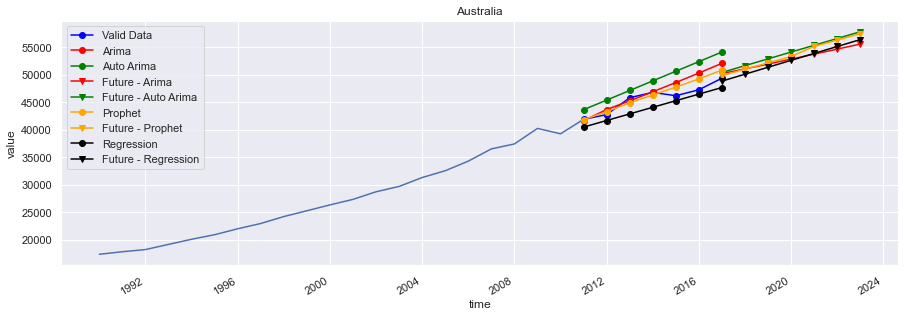

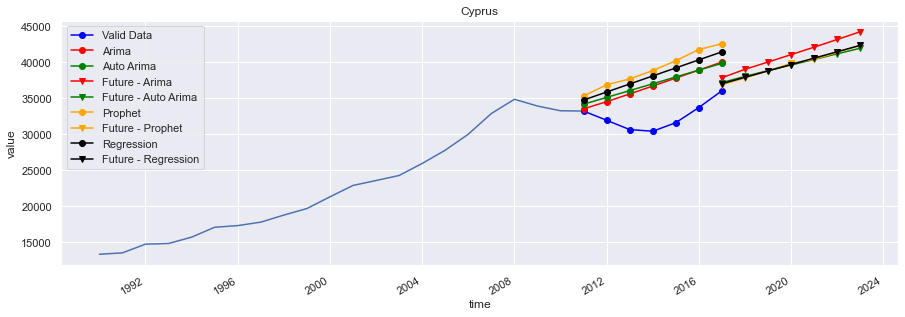

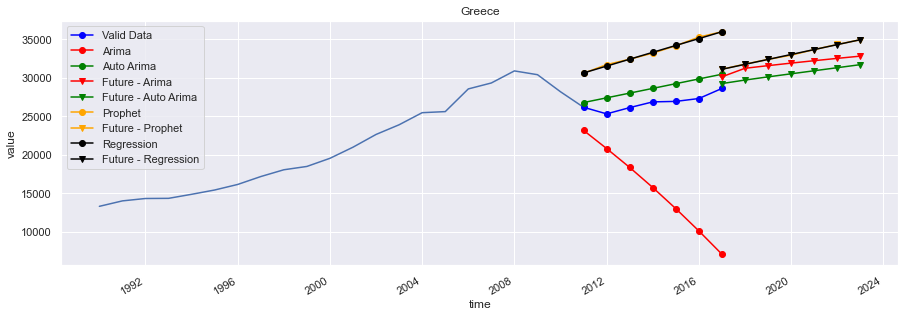

In [22]:
# Step 4 - Testing it on more countries

# creating a country list
countries = forecast_data['country'].unique()

countries = ['Australia', 'Cyprus', 'Greece']

for c in countries:
	# filtering the train data
	train_data = X_train[X_train['country'] == c]
	train_data2 = train_data[['time', 'value']]
	
	# filtering the valid data
	valid_data = X_valid[X_valid['country'] == c]
	valid_data2 = valid_data[['time', 'value']]
	
	# all data
	all_data = forecast_data[forecast_data['country']==c]
	all_data2 = all_data[['time', 'value']]
	
	#convert date column to datetime
	train_data2.set_index('time', inplace=True)
	valid_data2.set_index('time', inplace=True)
	valid_data2.columns = ['Valid Data']    
	all_data2.set_index('time', inplace=True)
	

	# Setting the Valid - Index for 6 years
	index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 
	
	# Setting the Future - Index for 6 years
	future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 
	
	# Dropping all tables
	try:
		del t_fcast1
		del t_fcast2
		del t_fcast3
		del t_fcast4
		
		del f_fcast1
		del f_fcast2
		del f_fcast3 
		del f_fcast4
		
	except:
		print("")

	try:
		del df_fcast1
		del df_fcast2
		del df_fcast3
		del df_fcast4
	except:
		print("")
		
	##############################################################################################################
	######################################            ARIMA             ##########################################  
	##############################################################################################################
	
	# THIS IS FOR THE VALIDATION PHASE 
	try:        
		try:
			# Running ARIMA on Best parameter
			model_arima = ARIMA(train_data2, order=(0,2,3))
			model_arima_fit = model_arima.fit(disp=-1)

			# Saving ARIMA predictions
			t_fcast1 = model_arima_fit.forecast(7)[0]
			# Passing the same index as the others
			t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
			t_fcast1 = t_fcast1.rename("Arima") 
		except:
			# Running ARIMA on Best parameter
			model_arima = ARIMA(train_data2, order=(4,1,0))
			model_arima_fit = model_arima.fit(disp=-1)

			# Saving ARIMA predictions
			t_fcast1 = model_arima_fit.forecast(7)[0]
			# Passing the same index as the others
			t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
			t_fcast1 = t_fcast1.rename("Arima") 
	except:
		print(c, "Arima Train Error")
		
	 # THIS IS FOR THE FUTURE PHASE
	try:        
		try:
			# Running ARIMA on Best parameter
			model_arima = ARIMA(all_data2, order=(0,2,3))
			model_arima_fit = model_arima.fit(disp=-1)

			# Saving ARIMA predictions
			f_fcast1 = model_arima_fit.forecast(7)[0]
			# Passing the same index as the others
			f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
			f_fcast1 = f_fcast1.rename("Future - Arima") 
		except:
			# Running ARIMA on Best parameter
			model_arima = ARIMA(all_data2, order=(4,1,0))
			model_arima_fit = model_arima.fit(disp=-1)

			# Saving ARIMA predictions
			f_fcast1 = model_arima_fit.forecast(7)[0]
			# Passing the same index as the others
			f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
			f_fcast1 = f_fcast1.rename("Future - Arima") 
	except:
		print(c, "Arima Future Error")   
		
	##############################################################################################################
	######################################      AUTO - ARIMA             ######################################### 
	##############################################################################################################
	
	# THIS IS FOR THE VALIDATION PHASE
	try:
		# Running auto ARIMA 
		auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

		# make your forecasts
		t_fcast2 = auto_arima_model.predict(7) 
		t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
		t_fcast2 = t_fcast2.rename("Auto Arima")

	except:
		print(c, "Auto Arima Train Error") 
		
	 # THIS IS FOR THE FUTURE PHASE
	try:
		# Running auto ARIMA Future
		auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

		# make your forecasts
		f_fcast2 = auto_arima_model.predict(7) 
		f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
		f_fcast2 = f_fcast2.rename("Future - Auto Arima")

	except:
		print(c, "Auto Arima Train Error")  

	##############################################################################################################
	######################################      PROPHET             ############################################## 
	##############################################################################################################
	
	# prepare expected column names
	train_data3 = train_data.copy()
	train_data3 = train_data3[['time', 'value']]
	train_data3.columns = ['ds', 'y']
	train_data3['ds']= to_datetime(train_data3['ds'])
	
	all_data3 = all_data.copy()
	all_data3 = all_data3[['time', 'value']]
	all_data3.columns = ['ds', 'y']
	all_data3['ds']= to_datetime(all_data3['ds'])

	# define the period for which we want a prediction - Valid
	v_df_index_7_years = pd.DataFrame(index_7_years)
	v_df_index_7_years.columns = ['ds']
	v_df_index_7_years['ds']= to_datetime(v_df_index_7_years['ds'])

	# define the period for which we want a prediction - Future
	f_df_index_7_years = pd.DataFrame(future_index_7_years)
	f_df_index_7_years.columns = ['ds']
	f_df_index_7_years['ds']= to_datetime(f_df_index_7_years['ds'])
	
	############### THIS IS FOR THE VALIDATION PHASE  ##################

	# define the model
	model = Prophet()
	# fit the model
	model.fit(train_data3)

	# use the model to make a forecast
	t_fcast3 = model.predict(v_df_index_7_years)
	t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_7_years)
	t_fcast3 = t_fcast3.rename("Prophet")
	
	############### THIS IS FOR THE VALIDATION PHASE  ##################

	# define the model
	model2 = Prophet()
	# fit the model
	model2.fit(all_data3)

	# use the model to make a forecast
	f_fcast3 = model2.predict(f_df_index_7_years)
	f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_7_years)
	f_fcast3 = f_fcast3.rename("Future - Prophet")  

	##############################################################################################################
	########################################         Regression         ##########################################
	##############################################################################################################
	
	# Creating Ordinal Dates
	train_data['MonthNumberOrdinal'] = train_data['time']
	train_data['MonthNumberOrdinal'] = pd.to_datetime(train_data['MonthNumberOrdinal']).map(datetime.toordinal)

	all_data['MonthNumberOrdinal'] = all_data['time']
	all_data['MonthNumberOrdinal'] = pd.to_datetime(all_data['MonthNumberOrdinal']).map(datetime.toordinal)

	# adding the ordinal dates to the prediction dates
	v_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(v_df_index_7_years['ds']).map(datetime.toordinal)
	f_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(f_df_index_7_years['ds']).map(datetime.toordinal)


	# Fitting LR on Valid
	reg = linear_model.LinearRegression()
	reg.fit(train_data['MonthNumberOrdinal'].values.reshape(-1, 1), train_data['value'].values)

	# Making predictions
	t_fcast4 = reg.predict(v_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

	# Passing the same index as the others
	t_fcast4 = pd.Series(t_fcast4, index=index_7_years)
	t_fcast4 = t_fcast4.rename("Regression")

	# Fitting LR on Future
	reg2 = linear_model.LinearRegression()
	reg2.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['value'].values)

	# Making predictions
	f_fcast4 = reg2.predict(f_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

	# Passing the same index as the others
	f_fcast4 = pd.Series(f_fcast4, index=future_index_7_years)
	f_fcast4 = f_fcast4.rename("Future - Regression")
	
	##############################################################################################################
	########################################      SAVING THE MSE        ##########################################
	##############################################################################################################
	
	t_fcast1_mse = mean_squared_error(valid_data['value'].values, t_fcast1.values, squared=False)
	t_fcast2_mse = mean_squared_error(valid_data['value'].values, t_fcast2.values, squared=False)
	t_fcast3_mse = mean_squared_error(valid_data['value'].values, t_fcast3.values, squared=False)
	t_fcast4_mse = mean_squared_error(valid_data['value'].values, t_fcast4.values, squared=False)
	
	##############################################################################################################
	########################################      PLOTTING              ##########################################
	##############################################################################################################
	
	fig, ax = plt.subplots(figsize=(15,5))
	chart = sns.lineplot(x='time', y='value', data = train_data)
	chart.set_title(c)
	valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
	# ploting validation
	try:
		t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
	except:
		print("")        
	try:
		t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
	except:
		print("")
		
	# plotting future
	try:
		f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
	except:
		print("")        
	try:
		f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
	except:
		print("") 
	
	t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
	f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)
	
	t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
	f_fcast4.plot(ax=ax, color='black', marker="v", legend=True)  
		
	##############################################################################################################
	########################################      SAVING THE RESULTS     #########################################
	##############################################################################################################
	
	try:
		# Creating a DF for fcast1
		t_fcast1 = t_fcast1.reset_index()
		t_fcast1.columns = ['Date','Arima ForecastValue Validation']

		f_fcast1 = f_fcast1.reset_index()
		f_fcast1.columns = ['Date','Arima ForecastValue Future']

		# Creating the extra columns
		t_fcast1['Arima ForecastValue Future'] = np.nan
		f_fcast1['Arima ForecastValue Validation'] = np.nan

		# reordering 1 only
		t_fcast1 = t_fcast1[['Date','Arima ForecastValue Future','Arima ForecastValue Validation']]

		# Joining them together
		df_fcast1 = pd.concat([t_fcast1, f_fcast1], axis=0)
		df_fcast1['Country'] = c
		df_fcast1['ML Method'] = 'Arima'
		df_fcast1['Arima MSE'] = t_fcast1_mse
	
	except:
		df_fcast1 = pd.DataFrame({'Date': [np.nan], 'Arima ForecastValue Future': [np.nan],'Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Arima']})

	try:
		# Creating a DF for fcast2
		t_fcast2 = t_fcast2.reset_index()
		t_fcast2.columns = ['Date','Auto-Arima ForecastValue Validation']

		f_fcast2 = f_fcast2.reset_index()
		f_fcast2.columns = ['Date','Auto-Arima ForecastValue Future']

		# Creating the extra columns
		t_fcast2['Auto-Arima ForecastValue Future'] = np.nan
		f_fcast2['Auto-Arima ForecastValue Validation'] = np.nan

		# reordering 1 only
		t_fcast2 = t_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation']]

		# Joining them together
		df_fcast2 = pd.concat([t_fcast2, f_fcast2], axis=0)
		df_fcast2['Country'] = c
		df_fcast2['ML Method'] = 'Auto-Arima'
		df_fcast2['Auto-Arima MSE'] = t_fcast2_mse
	
	except:
		df_fcast2 = pd.DataFrame({'Date': [np.nan], 'Auto-Arima ForecastValue Future': [np.nan],'Auto-Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
		
	try:
		# Creating a DF for fcast3
		t_fcast3 = t_fcast3.reset_index()
		t_fcast3.columns = ['Date','Prophet ForecastValue Validation']

		f_fcast3 = f_fcast3.reset_index()
		f_fcast3.columns = ['Date','Prophet ForecastValue Future']

		# Creating the extra columns
		t_fcast3['Prophet ForecastValue Future'] = np.nan
		f_fcast3['Prophet ForecastValue Validation'] = np.nan

		# reordering 1 only
		t_fcast3 = t_fcast3[['Date','Prophet ForecastValue Future','Prophet ForecastValue Validation']]

		# Joining them together
		df_fcast3 = pd.concat([t_fcast3, f_fcast3], axis=0)
		df_fcast3['Country'] = c
		df_fcast3['ML Method'] = 'Prophet'
		df_fcast3['Prophet MSE'] = t_fcast3_mse
	
	except:
		df_fcast3 = pd.DataFrame({'Date': [np.nan], 'Prophet ForecastValue Future': [np.nan],'Prophet ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
		
	try:
		# Creating a DF for fcast4
		t_fcast4 = t_fcast4.reset_index()
		t_fcast4.columns = ['Date','Regression ForecastValue Validation']

		f_fcast4 = f_fcast4.reset_index()
		f_fcast4.columns = ['Date','Regression ForecastValue Future']

		# Creating the extra columns
		t_fcast4['Regression ForecastValue Future'] = np.nan
		f_fcast4['Regression ForecastValue Validation'] = np.nan

		# reordering 1 only
		t_fcast4 = t_fcast4[['Date','Regression ForecastValue Future','Regression ForecastValue Validation']]

		# Joining them together
		df_fcast4 = pd.concat([t_fcast4, f_fcast4], axis=0)
		df_fcast4['Country'] = c
		df_fcast4['ML Method'] = 'Regression'
		df_fcast4['Regression MSE'] = t_fcast4_mse
		df_fcast4['Regression Slope'] = reg2.coef_[0]
		df_fcast4['Regression Trend Direction'] = np.where(df_fcast4['Regression Slope']<=0, 'Negative Trend', 'Positive Trend')
		df_fcast4['Regression Slope Monthly Change Proj'] = df_fcast4['Regression ForecastValue Future'].iloc[-1] - df_fcast4['Regression ForecastValue Future'].iloc[-2]
	
	except:
		df_fcast4 = pd.DataFrame({'Date': [np.nan], 'Regression ForecastValue Future': [np.nan],'Regression ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima'], 'Regression Slope':[np.nan], 'Regression Trend Direction':[np.nan], 'Regression Slope Monthly Change Proj':[np.nan]})
		
	# Aggregating the data to avoid duplication
	df_fcast1 = df_fcast1.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Arima ForecastValue Future':'sum','Arima ForecastValue Validation':'sum','Arima MSE':'max'})
	df_fcast2 = df_fcast2.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Auto-Arima ForecastValue Future':'sum','Auto-Arima ForecastValue Validation':'sum','Auto-Arima MSE':'max'})
	df_fcast3 = df_fcast3.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Prophet ForecastValue Future':'sum','Prophet ForecastValue Validation':'sum','Prophet MSE':'max'})
	df_fcast4 = df_fcast4.groupby(['Date', 'Country','ML Method', 'Regression Trend Direction'], as_index = False).agg({'Regression ForecastValue Future':'sum','Regression ForecastValue Validation':'sum','Regression MSE':'max','Regression Slope':'max','Regression Slope Monthly Change Proj':'max'})

	# joining them all together
	all_forecasts = df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')
	all_forecasts = all_forecasts.merge(df_fcast3[['Date','Prophet ForecastValue Future', 'Prophet ForecastValue Validation', 'Prophet MSE']], how = 'left', on ='Date')
	all_forecasts = all_forecasts.merge(df_fcast4[['Date','Regression ForecastValue Future', 'Regression ForecastValue Validation', 'Regression MSE', 'Regression Slope','Regression Slope Monthly Change Proj','Regression Trend Direction']], how = 'left', on ='Date')

	# Saving the predictions in a DF
	try:
		final_forecasts = pd.concat([final_forecasts, all_forecasts], ignore_index = True)
	except:
		final_forecasts = all_forecasts